<a href="https://colab.research.google.com/github/dgiri4132/pairs_trading_strategy-zscore/blob/main/Pairs_trading_Stratedy_using_zscore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import numpy as np
def get_company_name(ticker):
  try:
    return yf.Ticker(ticker).info.get('shortName')
  except:
    return None
option_for_index={'S&P500':'^GSPC','NASDAQ-100':'^NDX','Dow Jones':'^DJI','FTSE 100':'FTSE','Nikkei 225':'^N225','DAX':'^GDAXI','CAC 40':'^FCHI'}
while True:
  chosen_index_key=input(f"Choose anyone of the index from indexes below:{','.join(option_for_index.keys())} ").strip()
  if chosen_index_key in option_for_index:
    chosen_index = option_for_index[chosen_index_key]
    break
  else:
    print('Invalid index. Please try again.')
def index_tickers(chosen_index):
  try:
    if chosen_index=="^GSPC":
      df = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
      return df['Symbol'].tolist()
    elif chosen_index=='^NDX':
      df=pd.read_html('https://en.wikipedia.org/wiki/NASDAQ-100')[4]
      return df['Ticker'].tolist()
    elif chosen_index=='^DJI':
      df=pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')[2]
      return df['Symbol'].tolist()
    elif chosen_index=='FTSE':
      df=pd.read_html('https://en.wikipedia.org/wiki/FTSE_100_Index')[4]
      return df['EPIC'].tolist()
    elif chosen_index=='^N225':
      df=pd.read_html('https://en.wikipedia.org/wiki/Nikkei_225')[2]
      return df['Ticker'].tolist()
    elif chosen_index=='^GDAXI':
      df=pd.read_html('https://en.wikipedia.org/wiki/DAX')[2]
      return df['Ticker Symbol'].tolist()
    elif chosen_index=='^FCHI':
      df=pd.read_html('https://en.wikipedia.org/wiki/CAC_40')[1]
      return df['Ticker'].tolist()
    else:
      print('Index not recognized or supported')
      return None
  except Exception as e:
    print(f'Error loading tickers for {chosen_index}:{e}')
    return None
tickers=index_tickers(chosen_index)
tickers=[t.replace('.','-')for t in tickers]
start_date=input('Enter start date(yyyy-mm-dd): ').strip()
end_date=input('Enter end date(yyyy-mm-dd): ').strip()
start_dt=datetime.strptime(start_date,'%Y-%m-%d')
end_dt=datetime.strptime(end_date,'%Y-%m-%d')
num_days=np.busday_count(start_dt.date(),end_dt.date())
def data_download(tickers,start_date,end_date):
  data=yf.download(tickers,start=start_date,end=end_date,auto_adjust=False)['Adj Close']
  if isinstance(data.columns,pd.MultiIndex):
    data=data['Adj Close'].dropna(axis=1, how='all')
  else:
    data=data.dropna()
  return data.dropna(axis=1, how='any')
data=data_download(tickers,start_date,end_date)
print(f"{len(data.columns)} tickers with valid data out of {len(tickers)}")
if data.shape[1]<3:
  print('Not enough Valid stocks to compute pairwise correlations.')
  exit()
returns=data.pct_change().dropna()
correlation_matrix=returns.corr()
unstacked_corr=correlation_matrix.unstack()
filtered_pairs=unstacked_corr[unstacked_corr<1]
company_names={ticker: get_company_name(ticker) for ticker in data.columns}
filtered_pairs=filtered_pairs[filtered_pairs.index.map(lambda x: company_names.get(x[0]) != company_names.get(x[1]))]
unique_pairs=filtered_pairs.drop_duplicates()
num_pairs=int(input('Enter the number of top correlated pairs to analyze: ').strip())
top_pairs=unique_pairs.sort_values(ascending=False).head(num_pairs)
if len(top_pairs)==0:
  print('No strong correlations found. Try a different index or time range')
elif len(top_pairs)==1:
  print('Only one pair found. Procceding with the limited data. ')
else:
  print(f'found {len(top_pairs)} top correlated pairs: ')
  print(top_pairs)

Choose anyone of the index from indexes below:S&P500,NASDAQ-100,Dow Jones,FTSE 100,Nikkei 225,DAX,CAC 40 S&P500
Enter start date(yyyy-mm-dd): 2023-10-01
Enter end date(yyyy-mm-dd): 2024-08-01


[*********************100%***********************]  503 of 503 completed


503 tickers with valid data out of 503
Enter the number of top correlated pairs to analyze: 5
found 5 top correlated pairs: 
Ticker  Ticker
AMAT    LRCX      0.962827
        KLAC      0.952719
KLAC    LRCX      0.930492
LEN     PHM       0.928045
MLM     VMC       0.921041
dtype: float64


Choose Strategy mode: (1)Top Pair Only (2) Multi-Pair Portfolio; Enter 1 or 2: 1
Enter z-score threshold for AMAT-LRCX (default is +/- 1): 1
Final return from AMAT-LRCX strategy: 1.04
Sharpe Ratio(adjusted for period): 0.87


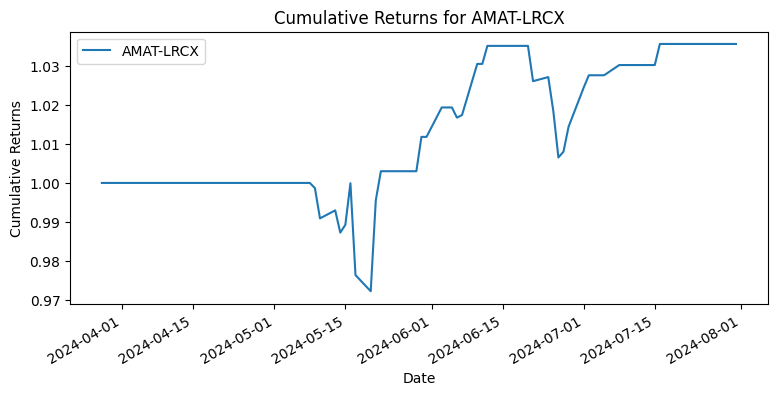

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
mode=''
while mode not in ['1','2']:
  mode=input('Choose Strategy mode: (1)Top Pair Only (2) Multi-Pair Portfolio; Enter 1 or 2: ').strip()
def calculate_zscore(spread,window=30):
  rolling_mean=spread.rolling(window).mean()
  rolling_std=spread.rolling(window).std()
  return (spread-rolling_mean)/rolling_std
def signals(zscore, threshold=1):
  signal=pd.Series(index=zscore.index,dtype='float64')
  signal[zscore>threshold]=-1
  signal[zscore<-threshold]=1
  signal[(zscore<=threshold)&(zscore>=-threshold)]=0
  return signal.ffill().fillna(0)
portfolio_returns=[]
pair_labels=[]
for idx, i in enumerate(top_pairs.index):
  stock_1,stock_2=i
  stock_1_norm=data[stock_1]/data[stock_1].iloc[0]
  stock_2_norm=data[stock_2]/data[stock_2].iloc[0]
  spread=stock_1_norm-stock_2_norm
  zscore=calculate_zscore(spread,window=30)
  threshold=float(input(f'Enter z-score threshold for {stock_1}-{stock_2} (default is +/- 1): ').strip())
  signals_df=signals(zscore, threshold)
  spread_returns=returns[stock_1]-returns[stock_2]
  strategy_returns=signals_df.shift(1)*spread_returns

  if mode=='1' and idx==0:
    cumulative_returns=(1+strategy_returns).cumprod()
    rf_daily=0.03/252
    excess_returns=strategy_returns-rf_daily
    sharpe= excess_returns.mean()/excess_returns.std()*np.sqrt(num_days) if excess_returns.std()!=0 else np.nan
    print(f'Final return from {stock_1}-{stock_2} strategy: {cumulative_returns.iloc[-1]:.2f}')
    print(f'Sharpe Ratio(adjusted for period): {sharpe:.2f}')
    plt.figure(figsize=(9,4))
    cumulative_returns.plot(label=f'{stock_1}-{stock_2}')
    plt.title(f'Cumulative Returns for {stock_1}-{stock_2}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.show()
    break
  elif mode=='2':
    portfolio_returns.append(strategy_returns)
    pair_labels.append(f'{stock_1}-{stock_2}')
if mode=='2' and portfolio_returns:
  port_ret_df=pd.concat(portfolio_returns,axis=1)
  portfolio_return_series=port_ret_df.mean(axis=1)
  cumulative_returns=(1+portfolio_return_series).cumprod()
  rf_daily=0.03/252
  excess_returns=portfolio_return_series-rf_daily
  sharpe= excess_returns.mean()/excess_returns.std()*np.sqrt(num_days) if excess_returns.std()!=0 else np.nan
  print(f'Final return from Portfolio strategy: {cumulative_returns.iloc[-1]:.2f}')
  print(f'Sharpe Ratio(adjusted for period): {sharpe:.2f}')
  plt.figure(figsize=(9,4))
  cumulative_returns.plot(label='Portfolio Strategy')
  plt.xlabel('Date')
  plt.ylabel('Cumulative Returns')
  plt.legend()
  plt.show()